## Calibration simulation

This simulates the calibration of an ANSTO two-filter radon detector by injecting radon from a known-activity source into the inlet line, assuming that the ambient radon concentration is zero.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import generated_functions as gf

In [3]:
# radon decay constant (/s)
lambda_radon = 2.100140526711101e-6

In [4]:
# conversion factors
lpm_to_m3sec = 1/1000/60

*detector-specific parameters, play with these*

In [5]:
# internal flow rate (m3/sec)
Q = 0.0122
# external flow rate (m3/sec)
Q_external = 80.0 * lpm_to_m3sec
# volume of external delay tank (m3)
V_delay = 0.2
# volume of internal delay volume (m3)
V_tank = 0.7
# additional delay (to account for long inlet line from tower etc.)
t_delay = 0.0

*"universal" model parameters, leave these fixed*

In [6]:
# screen capture efficiency (0-1)
rs = 0.95
# internal plateout constant (/s)
lamp = 0.005555555555555556
# alpha detection efficiency (0-1)
# --- note: this is set below, based on "total_efficiency"
eff = 1
# recoil probability (0-1)
recoil_prob = 0.025

*parameters describing calibration setup (can be adjusted, but main result below is insensitive to everything here except for the calibration duration)*

In [7]:
# detector cps per ambient Bq/m3 of radon
total_efficiency = 0.15
cal_source_strength = 20e3 # kBq
cal_begin = 3600.0
cal_duration = 3600.0*6
# radon Bq/m3 in calibration gas
Ncal = cal_source_strength / Q_external * lambda_radon

In [20]:
# adjust "eff" so that the total efficiency is equal to that 
# given above
sscps_initial = gf.steady_state_count_rate(rs, recoil_prob, V_tank, Q, lamp, eff)
eff = eff/sscps_initial*total_efficiency

0.1438079901237011
0.154


In [8]:
# t - time grid, 1min samples
t = np.arange(0,10*3600,60)

*calculate the number of radon progeny arriving at internal filter (normalised by radon concentration)*

In [9]:
N_af, N_bf = gf.calc_na_nb_factors(Q, lamp, V_tank)

*calculate the total number of counts detected since t = 0*

In [10]:
tc = gf.tc_integral_calibration(Ncal, rs, recoil_prob, V_tank, Q, cal_begin, N_bf, N_af, t, Q_external, eff, cal_duration)

*calculate count rate expected at steady-state*

In [11]:
sscps = gf.steady_state_count_rate(rs, recoil_prob, V_tank, Q, lamp, eff) * Ncal

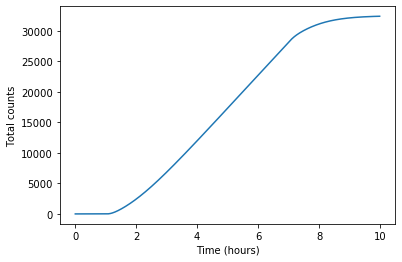

In [12]:
fig, ax = plt.subplots()
ax.plot(t/3600., tc)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Total counts');

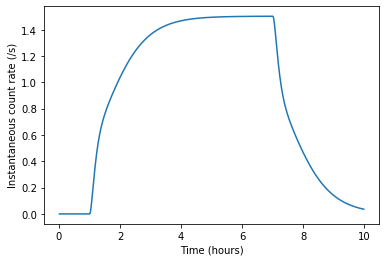

In [13]:
fig, ax = plt.subplots()
ax.plot(t[1:]/3600., np.diff(tc)/np.diff(t))
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Instantaneous count rate (/s)');

In [14]:
df = pd.DataFrame({'total_counts': tc}, index=t.astype(int))

## Report counts/expected counts

This code looks up the total counts recorded by the detector over each hour since the calibration begun, and the compares this to the expected steady-state count rate.

In [15]:
results_list = []

for ii in range(int(cal_duration/3600.0)):
    t0 = int(ii*3600.0 + cal_begin)
    t1 = int((ii+1)*3600.0 + cal_begin)
    counts_during_interval = (df.loc[t1] - df.loc[t0]).values[0]
    average_count_rate_during_interval = counts_during_interval / 3600.0
    
    dfr = pd.DataFrame({'interval_start': [t0-cal_begin], 
                        'interval_stop': [t1-cal_begin],
                        'counts_during_interval': [counts_during_interval],
                        'steady_state_divided_by_actual_count_rate': 
                        [sscps / average_count_rate_during_interval]})
    results_list.append(dfr)
    
dfr = pd.concat(results_list, ignore_index=True)
dfr

,interval_start,interval_stop,counts_during_interval,steady_state_divided_by_actual_count_rate
0,0.0,3600.0,2436.184492,2.220217
1,3600.0,7200.0,4417.942904,1.224294
2,7200.0,10800.0,5137.125519,1.052896
3,10800.0,14400.0,5343.621365,1.012208
4,14400.0,18000.0,5394.089076,1.002738
5,18000.0,21600.0,5405.612437,1.000601
